# An on-line movie recommending service using Spark & Flask - Building the recommender

This notebook explains how to use the MovieLens dataset to build a movie recommender using collaborative filtering with Spark's Alternating Least Saqures implementation. It is organised in two parts. The first one is about getting and parsing movies and ratings data into Spark RDDs. The second is about building and using the recommender and persisting it for later use in our on-line recommender system.

This tutorial can be used independently to build a movie recommender model based on the MovieLens dataset. Most of the code in this first part, about how to use ALS with the public MovieLens dataset, comes from my solution to one of the exercises proposed in the CS100.1x Introduction to Big Data with Apache Spark by Anthony D. Joseph on edX, that is also publicly available since 2014 at Spark Summit . There I've added with minor modifications to use a larger dataset and also code about how to store and reload the model for later use.

# Getting and processing the data
In order to build an on-line movie recommender using Spark, we need to have our model data as preprocessed as possible. Parsing the dataset and building the model everytime a new recommendation needs to be done is not the best of the strategies.

The list of task we can pre-compute includes:

Loading and parsing the dataset. Persisting the resulting RDD for later use.
Building the recommender model using the complete dataset. Persist the dataset for later use.
This notebook explains the first of these tasks.

## File download
GroupLens Research has collected and made available rating data sets from the MovieLens web site. The data sets were collected over various periods of time, depending on the size of the set. They can be found here.

In our case, we will use the latest datasets:

Small: 100,000 ratings and 2,488 tag applications applied to 8,570 movies by 706 users. Last updated 4/2015.
Full: 21,000,000 ratings and 470,000 tag applications applied to 27,000 movies by 230,000 users. Last updated 4/2015.

In [1]:
complete_dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip'
small_dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

We also need to define download locations.

In [2]:
small_dataset_path = 'datasets/ml-latest-small.zip'
complete_dataset_path = 'datasets/ml-latest.zip'

import os
if not os.path.exists('datasets'):
    os.makedirs('datasets')

datasets_path = os.path.join('..', 'datasets')

Now we can proceed with both downloads.

In [3]:
import urllib.request

small_f = urllib.request.urlretrieve(small_dataset_url, small_dataset_path)
complete_f = urllib.request.urlretrieve(complete_dataset_url, complete_dataset_path)

Both of them are zip files containing a folder with ratings, movies, etc. We need to extract them into its individual folders so we can use each file later on.

In [4]:
import zipfile

with zipfile.ZipFile(small_dataset_path, "r") as z:
    z.extractall(datasets_path)

with zipfile.ZipFile(complete_dataset_path, "r") as z:
    z.extractall(datasets_path)

## Loading and parsing datasets
No we are ready to read in each of the files and create an RDD consisting of parsed lines.

Each line in the ratings dataset (`ratings.csv`) is formatted as:

`userId,movieId,rating,timestamp`

Each line in the movies (`movies.csv`) dataset is formatted as:

`movieId,title,genres`

Were genres has the format:

`Genre1|Genre2|Genre3...`

The tags file (`tags.csv`) has the format:

`userId,movieId,tag,timestamp`

And finally, the `links.csv` file has the format:

`movieId,imdbId,tmdbId`

The format of these files is uniform and simple, so we can use Python `split()` to parse their lines once they are loaded into RDDs. Parsing the movies and ratings files yields two RDDs:

For each line in the ratings dataset, we create a tuple of `(UserID, MovieID, Rating)`. We drop the timestamp because we do not need it for this recommender.
For each line in the movies dataset, we create a tuple of `(MovieID, Title)`. We drop the genres because we do not use them for this recommender.
So let's load the raw ratings data. We need to filter out the header, included in each file.

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [9]:
import findspark
findspark.init()

In [10]:
from pyspark import SparkContext, SparkConf

sc = SparkContext.getOrCreate()

if sc.master == "local[*]":
    conf = SparkConf().setAppName("MovieLensALS").setMaster("local[*]").set("spark.driver.memory", "4g").set("spark.driver.extraJavaOptions", "-Xss8M")
    sc.stop()
    sc = SparkContext(conf=conf)

In [11]:
small_ratings_file = os.path.join(datasets_path, 'ml-latest-small', 'ratings.csv')

small_ratings_raw_data = sc.textFile(small_ratings_file)
small_ratings_raw_data_header = small_ratings_raw_data.take(1)[0]

Now we can parse the raw data into a new RDD.

In [12]:
small_ratings_data = small_ratings_raw_data.filter(lambda line: line!=small_ratings_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

For illustrative purposes, we can take the first few lines of our RDD to see the result. In the final script we don't call any Spark action (e.g. `take`) until needed, since they trigger actual computations in the cluster.

In [13]:
small_ratings_data.take(3)

[('1', '1', '4.0'), ('1', '3', '4.0'), ('1', '6', '4.0')]

We proceed in a similar way with the `movies.csv` file.

In [14]:
small_movies_file = os.path.join(datasets_path, 'ml-latest-small', 'movies.csv')

small_movies_raw_data = sc.textFile(small_movies_file)
small_movies_raw_data_header = small_movies_raw_data.take(1)[0]

small_movies_data = small_movies_raw_data.filter(lambda line: line!=small_movies_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1])).cache()
    
small_movies_data.take(3)

[('1', 'Toy Story (1995)'),
 ('2', 'Jumanji (1995)'),
 ('3', 'Grumpier Old Men (1995)')]

The following sections introduce Collaborative Filtering and explain how to use Spark MLlib to build a recommender model. We will close the tutorial by explaining how a model such this is used to make recommendations, and how to persist it for later use (e.g. in our Python/flask web-service).

# Collaborative Filtering
In Collaborative filtering we make predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption is that if a user A has the same opinion as a user B on an issue, A is more likely to have B's opinion on a different issue x than to have the opinion on x of a user chosen randomly.

The image below (from Wikipedia) shows an example of collaborative filtering. At first, people rate different items (like videos, images, games). Then, the system makes predictions about a user's rating for an item not rated yet. The new predictions are built upon the existing ratings of other users with similar ratings with the active user. In the image, the system predicts that the user will not like the video.

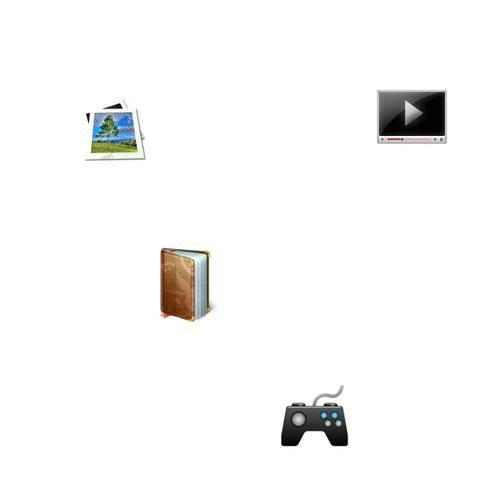

Spark MLlib library for Machine Learning provides a Collaborative Filtering implementation by using Alternating Least Squares. The implementation in MLlib has the following parameters:

- numBlocks is the number of blocks used to parallelize 
computation (set to -1 to auto-configure).
- rank is the number of latent factors in the model.
iterations is the number of iterations to run.
- lambda specifies the regularization parameter in ALS.
- implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data.
- alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations.

# Selecting ALS parameters using the small dataset
In order to determine the best ALS parameters, we will use the small dataset. We need first to split it into train, validation, and test datasets.

In [15]:
training_RDD, validation_RDD, test_RDD = small_ratings_data.randomSplit([6, 2, 2], seed=0)
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

Now we can proceed with the training phase.

In [16]:
from pyspark.mllib.recommendation import ALS
import math

seed = 5
iterations = 10
regularization_parameter = 0.1
ranks = [4, 8, 12]
errors = [0, 0, 0]
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1
for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,
                      lambda_=regularization_parameter)
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print ('For rank %s the RMSE is %s' % (rank, error))
    if error < min_error:
        min_error = error
        best_rank = rank

print ('The best model was trained with rank %s' % best_rank)

For rank 4 the RMSE is 0.9121002114021121
For rank 8 the RMSE is 0.9184327213070025
For rank 12 the RMSE is 0.9160151537868968
The best model was trained with rank 4


But let's explain this a little bit. First, let's have a look at how our predictions look.

In [17]:
predictions.take(3)

[((372, 1084), 3.606783397597423),
 ((4, 1084), 3.653744361967948),
 ((402, 1084), 3.5469004231749226)]

Basically we have the UserID, the MovieID, and the Rating, as we have in our ratings dataset. In this case the predictions third element, the rating for that movie and user, is the predicted by our ALS model.

Then we join these with our validation data (the one that includes ratings) and the result looks as follows:

In [18]:
rates_and_preds.take(3)

[((1, 457), (5.0, 4.478201277281334)),
 ((1, 1025), (5.0, 4.508338559183116)),
 ((1, 1089), (5.0, 4.927108181828176))]

To that, we apply a squared difference and the we use the `mean()` action to get the MSE and apply `sqrt`.

Finally we test the selected model.

In [19]:
model = ALS.train(training_RDD, best_rank, seed=seed, iterations=iterations,
                      lambda_=regularization_parameter)
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.9121326039222192


Using the complete dataset to build the final model
In order to build our recommender model, we will use the complete dataset. Therefore, we need to process it the same way we did with the small dataset.

In [20]:
# Load the complete dataset file
complete_ratings_file = os.path.join(datasets_path, 'ml-latest', 'ratings.csv')
complete_ratings_raw_data = sc.textFile(complete_ratings_file)
complete_ratings_raw_data_header = complete_ratings_raw_data.take(1)[0]

# Parse
complete_ratings_data = complete_ratings_raw_data.filter(lambda line: line!=complete_ratings_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()
    
print ("There are %s recommendations in the complete dataset" % (complete_ratings_data.count()))

There are 27753444 recommendations in the complete dataset


Now we are ready to train the recommender model.

In [21]:
training_RDD, test_RDD = complete_ratings_data.randomSplit([7, 3], seed=0)

complete_model = ALS.train(training_RDD, best_rank, seed=seed, 
                           iterations=iterations, lambda_=regularization_parameter)

Now we test on our testing set.

In [22]:
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

predictions = complete_model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.8334782410156314


We can see how we got a more accurate recommender when using a much larger dataset.

# How to make recommendations
Although we aim at building an on-line movie recommender, now that we know how to have our recommender model ready, we can give it a try providing some movie recommendations. This will help us coiding the recommending engine later on when building the web service, and will explain how to use the model in any other circumstances.

When using collaborative filtering, getting recommendations is not as simple as predicting for the new entries using a previously generated model. Instead, we need to train again the model but including the new user preferences in order to compare them with other users in the dataset. That is, the recommender needs to be trained every time we have new user ratings (although a single model can be used by multiple users of course!). This makes the process expensive, and it is one of the reasons why scalability is a problem (and Spark a solution!). Once we have our model trained, we can reuse it to obtain top recomendations for a given user or an individual rating for a particular movie. These are less costly operations than training the model itself.

So let's first load the movies complete file for later use.

In [23]:
complete_movies_file = os.path.join(datasets_path, 'ml-latest', 'movies.csv')
complete_movies_raw_data = sc.textFile(complete_movies_file)
complete_movies_raw_data_header = complete_movies_raw_data.take(1)[0]

# Parse
complete_movies_data = complete_movies_raw_data.filter(lambda line: line!=complete_movies_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1],tokens[2])).cache()

complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]),x[1]))
    
print ("There are %s movies in the complete dataset" % (complete_movies_titles.count()))

There are 58098 movies in the complete dataset


Another thing we want to do, is give recommendations of movies with a certain minimum number of ratings. For that, we need to count the number of ratings per movie.



In [24]:
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

movie_ID_with_ratings_RDD = (complete_ratings_data.map(lambda x: (x[1], x[2])).groupByKey())
movie_ID_with_avg_ratings_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)
movie_rating_counts_RDD = movie_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][0]))

# Adding new user ratings
Now we need to rate some movies for the new user. We will put them in a new RDD and we will use the user ID 0, that is not assigned in the MovieLens dataset. Check the dataset movies file for ID to Tittle assignment (so you know what movies are you actually rating).

In [26]:
new_user_ID = 0

# The format of each line is (userID, movieID, rating)
new_user_ratings = [
     (0,260,9), # Star Wars (1977)
     (0,1,8), # Toy Story (1995)
     (0,16,7), # Casino (1995)
     (0,25,8), # Leaving Las Vegas (1995)
     (0,32,9), # Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
     (0,335,4), # Flintstones, The (1994)
     (0,379,3), # Timecop (1994)
     (0,296,7), # Pulp Fiction (1994)
     (0,858,10) , # Godfather, The (1972)
     (0,50,8) # Usual Suspects, The (1995)
    ]
new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print ('New user ratings: %s' % new_user_ratings_RDD.take(10))

New user ratings: [(0, 260, 9), (0, 1, 8), (0, 16, 7), (0, 25, 8), (0, 32, 9), (0, 335, 4), (0, 379, 3), (0, 296, 7), (0, 858, 10), (0, 50, 8)]


Now we add them to the data we will use to train our recommender model. We use Spark's `union()` transformation for this.

In [27]:
complete_data_with_new_ratings_RDD = complete_ratings_data.union(new_user_ratings_RDD)

And finally we train the ALS model using all the parameters we selected before (when using the small dataset).

In [29]:
from time import time

t0 = time()
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed=seed, 
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print ("New model trained in %s seconds" % round(tt,3))

New model trained in 232.559 seconds


It took some time. We will need to repeat that every time a user add new ratings. Ideally we will do this in batches, and not for every single rating that comes into the system for every user.

# Getting top recommendations
Let's now get some recommendations! For that we will get an RDD with all the movies the new user hasn't rated yet. We will them together with the model to predict ratings.

In [30]:
new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just movie IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() to predict new ratings for the movies
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

We have our recommendations ready. Now we can print out the 25 movies with the highest predicted ratings. And join them with the movies RDD to get the titles, and ratings count in order to get movies with a minimum number of counts. First we will do the join and see what does the result looks like.

In [31]:
# Transform new_user_recommendations_RDD into pairs of the form (Movie ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(complete_movies_titles).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

[(6216,
  ((7.173385575542827, 'Nowhere in Africa (Nirgendwo in Afrika) (2001)'),
   717)),
 (124320, ((7.359570359697489, 'Once a Thief (1965)'), 1)),
 (83916, ((6.125867721800745, 'Blues in the Night (1941)'), 9))]

So we need to flat this down a bit in order to have `(Title, Rating, Ratings Count)`.

In [32]:
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

Finally, get the highest rated recommendations for the new user, filtering out movies with less than 25 ratings.

In [33]:
top_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=25).takeOrdered(25, key=lambda x: -x[1])

print ('TOP recommended movies (with more than 25 reviews):\n%s' %
        '\n'.join(map(str, top_movies)))

TOP recommended movies (with more than 25 reviews):
('Rabbit of Seville (1950)', 8.60283332885939, 30)
("Jim Henson's The Storyteller (1989)", 8.544291232021493, 36)
('"Godfather', 8.52628915469041, 60904)
('Cosmos', 8.52467364564589, 157)
('Death on the Staircase (Soupçons) (2004)', 8.521656039332541, 130)
('Music for One Apartment and Six Drummers (2001)', 8.502821262499474, 31)
('"Human Condition III', 8.495127363853982, 91)
('Harakiri (Seppuku) (1962)', 8.494578606156566, 679)
('"I', 8.424360308543928, 85)
('Planet Earth (2006)', 8.424323803290726, 1384)
('Seven Samurai (Shichinin no samurai) (1954)', 8.400267161867603, 14578)
('Planet Earth II (2016)', 8.398935611848366, 853)
('Elway To Marino (2013)', 8.391344843680827, 25)
('"Last Lions', 8.391119159344683, 38)
('Baseball (1994)', 8.390721419421908, 42)
('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 8.388162211448673, 29484)
('"Godfather: Part II', 8.375398278118837, 38875)
('The Godfather Trilog

# Getting individual ratings
Another useful usecase is getting the predicted rating for a particular movie for a given user. The process is similar to the previous retreival of top recommendations but, instead of using `predcitAll` with every single movie the user hasn't rated yet, we will just pass the method a single entry with the movie we want to predict the rating for.

In [34]:
my_movie = sc.parallelize([(0, 500)]) # Quiz Show (1994)
individual_movie_rating_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)
individual_movie_rating_RDD.take(1)

[Rating(user=0, product=116688, rating=2.070225567265668)]

Not very likely that the new user will like that one... Obviously we can include as many movies as we need in that list!

# Persisting the model
Optionally, we might want to persist the base model for later use in our on-line recommendations. Although a new model is generated everytime we have new user ratings, it might be worth it to store the current one, in order to save time when starting up the server, etc. We might also save time if we persist some of the RDDs we have generated, specially those that took longer to process. For example, the following lines save and load a ALS model.

In [35]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_path = os.path.join('..', 'models', 'movie_lens_als')

# Save and load model
model.save(sc, model_path)
same_model = MatrixFactorizationModel.load(sc, model_path)

Among other things, you will see in your filesystem that there are folder with product and user data into Parquet format files.

# Genre and other fields
We havent used the `genre` and `timestamp` fields in order to simplify the transformations and the whole tutorial. Incorporating them doesn't reprensent any problem. A good use could be filtering recommendations by any of them (e.g. recommendations by genre, or recent recommendations) like we have done with the minimum number of ratings.

# Exercise
In this example, rank is the only hyperparameter with value variation. Add additional inner loop to combine it with iteration using values 5, 10, and 20.

In [36]:
seed = 5
regularization_parameter = 0.1
ranks = [4, 8, 12]
iterations_list = [5, 10, 20]
tolerance = 0.02

In [37]:
min_error = float('inf')
best_rank = -1
best_iteration = -1

In [38]:
for rank in ranks:
    for iterations in iterations_list:
        model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,
                          lambda_=regularization_parameter)
        predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
        rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
        error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        print('For rank %s and iteration %s the RMSE is %s' % (rank, iterations, error))
        if error < min_error:
            min_error = error
            best_rank = rank
            best_iteration = iterations

For rank 4 and iteration 5 the RMSE is 1.0990149964396436
For rank 4 and iteration 10 the RMSE is 1.105242106906042
For rank 4 and iteration 20 the RMSE is 1.0993634344211707
For rank 8 and iteration 5 the RMSE is 1.1190397767017635


KeyboardInterrupt: ignored

In [39]:
print('The best model was trained with rank %s and iteration %s' % (best_rank, best_iteration))

The best model was trained with rank 4 and iteration 5
